In [196]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as an
import gseapy as gp
import scanpy as sc
import infercnvpy as cnv

import sys
sys.path.insert(1, '../mhCompTiss/')

import scanpyHelpers as scH

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


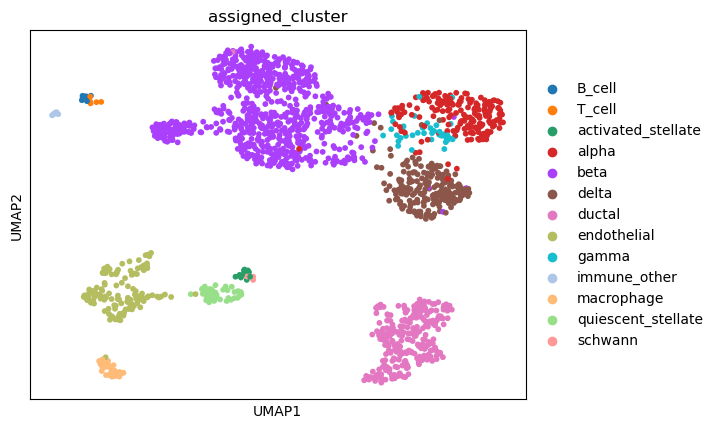

In [187]:
pdata = sc.read_h5ad('../mhCompTiss/write/pancreasMouse.h5ad')
sc.pl.umap(pdata, color=["assigned_cluster"])

In [189]:
pdata = pdata.raw.to_adata()

In [71]:
mouseGenes = pd.read_table("data/Mus_musculus.GRCm39.112.gtf", skiprows=5, header=None, usecols=[0,2,3,4,8])
mouseGenes = mouseGenes[mouseGenes.iloc[:,1]=="gene"]
mouseGenes

/tmp/ipykernel_3509990/4118323706.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  mouseGenes = pd.read_table("data/Mus_musculus.GRCm39.112.gtf", skiprows=5, header=None, usecols=[0,2,3,4,8])


,0,2,3,4,8
0,1,gene,108344807,108347562,"gene_id ""ENSMUSG00000104478""; gene_version ""2""..."
3,1,gene,6980784,6981446,"gene_id ""ENSMUSG00000104385""; gene_version ""2""..."
6,1,gene,108540067,108540244,"gene_id ""ENSMUSG00000101231""; gene_version ""2""..."
9,1,gene,6986783,6993812,"gene_id ""ENSMUSG00000102135""; gene_version ""2""..."
13,1,gene,6999983,7000012,"gene_id ""ENSMUSG00000103282""; gene_version ""2""..."
...,...,...,...,...,...
1889856,GL456239.1,gene,38438,38535,"gene_id ""ENSMUSG00002075400""; gene_version ""1""..."
1889859,GL456385.1,gene,31243,31343,"gene_id ""ENSMUSG00002074970""; gene_version ""1""..."
1889862,GL456385.1,gene,32719,32818,"gene_id ""ENSMUSG00002075729""; gene_version ""1""..."
1889865,GL456372.1,gene,13262,13382,"gene_id ""ENSMUSG00002074899""; gene_version ""1""..."


In [72]:
geneNames = np.full(len(mouseGenes.index),"", dtype="object")
for i,mouseInfo in enumerate(mouseGenes.index):
    for info in mouseGenes.loc[mouseInfo,8].split("; "):
        try:
            label, dat = info.split(" ")
            if label=="gene_name":
                geneNames[i] = dat[1:-1]
                continue
        except:
            continue

In [73]:
mouseGenes.iloc[:,4] = geneNames
mouseGenes= mouseGenes[geneNames!=""]
mouseGenes.iloc[:,0] = ["chr"+str(num) for num in mouseGenes.iloc[:,0]]
mouseGenes.columns = ["chromosome","gene","start","end","name"]
mouseGenes.index = mouseGenes["name"]
mouseGenes = mouseGenes[["chromosome","start","end"]]
mouseGenes

,chromosome,start,end
name,,,
Gm38212,chr1,108344807,108347562
Gm7449,chr1,6980784,6981446
Gm28283,chr1,108540067,108540244
Gm37108,chr1,6986783,6993812
Gm37275,chr1,6999983,7000012
...,...,...,...
mt-Tt,chrMT,15289,15355
mt-Tp,chrMT,15356,15422
Gm16367,chrJH584299.1,477246,480331


In [75]:
mouseGenes.to_csv("data/MouseGenePos.csv")

In [27]:
writeDir = "write/"

fileName = "pdacMouseMrtx"
#fileName = "pdacPdxMrtx"

resultsFile = writeDir + fileName + '.h5ad'       # final output
resultsFileTotal = writeDir + fileName + 'wImm.h5ad'       # final output
resultsFileQC = writeDir + fileName + '_QC.h5ad'  # post QC (pre-analysis) 

In [81]:
adata = sc.read_h5ad(resultsFile)
adata

AnnData object with n_obs × n_vars = 6782 × 1589
    obs: 'BFP', 'CLuc', 'CreER', 'DTR', 'EGFP', 'GLuc', 'luciferase', 'mScarlet', 'tdTomato', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'GMM', 'treatment', 'leiden', 'tdT+', 'EGFP+', 'tumor', 'scBasalScore', 'scClassicalScore', 'EMTScore', 'cellState', 'decoupler', 'zsig'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mt'
    uns: 'EGFP+_colors', 'GMM_colors', 'cellState_colors', 'decoupler_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'tdT+_colors', 'treatment_colors', 

In [82]:
mrtxVehCmap = {"veh":'#ff7f0e',"mrtx":'#1f77b4'}

cellStateColDict = {"EMT":'#1f77b4', "basal":'#ff7f0e', "classical":'#279e68', "inter":'#d62728'}
#cellStateCols = [cellStateColDict[cs] for cs in adata.obs.cellState]

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

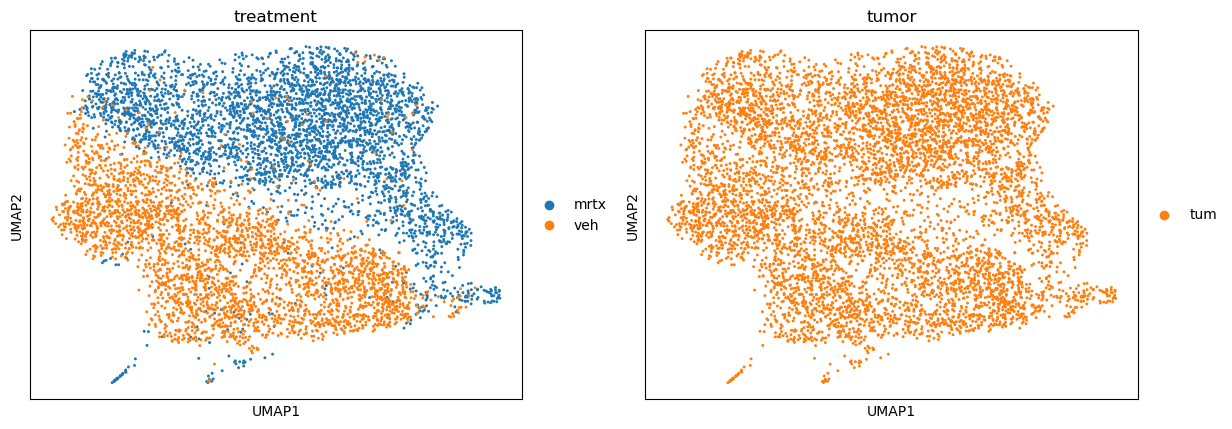

In [83]:
sc.pl.umap(adata, color=["treatment","tumor"])

In [84]:
cellstate = adata.obs.cellState

In [192]:
adata = sc.read_h5ad(resultsFileQC)
adata = adata[cellstate.index]
adata

View of AnnData object with n_obs × n_vars = 6782 × 17519
    obs: 'BFP', 'CLuc', 'CreER', 'DTR', 'EGFP', 'GLuc', 'luciferase', 'mScarlet', 'tdTomato', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'GMM', 'treatment'

In [193]:
adata.obs["cellState"] = cellstate
adata.obs

/tmp/ipykernel_3509990/2281070606.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["cellState"] = cellstate


,BFP,CLuc,CreER,DTR,EGFP,GLuc,luciferase,mScarlet,tdTomato,n_genes,...,pct_counts_mt,most_likely_hypothesis,cluster_feature,negative_hypothesis_probability,singlet_hypothesis_probability,doublet_hypothesis_probability,Classification,GMM,treatment,cellState
AAACCCACATAGAGGC-1-mrtx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3643,...,2.330416,1,0,0.000259,0.971943,0.027798,AK1662_MRTX_B0304,Negative,mrtx,basal
AAACGAAAGGAGACCT-1-mrtx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3801,...,2.898402,1,0,0.000394,0.891351,0.108255,AK1662_MRTX_B0304,Negative,mrtx,classical
AAACGAAAGTCTTCGA-1-mrtx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2761,...,3.620029,1,0,0.002119,0.871690,0.126191,AK1662_MRTX_B0304,Negative,mrtx,classical
AAACGAAAGTGCCGAA-1-mrtx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3390,...,2.200079,1,0,0.001937,0.987539,0.010524,AK1662_MRTX_B0304,Negative,mrtx,classical
AAACGAACACCTCTAC-1-mrtx,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2536,...,2.963841,1,0,0.000231,0.921341,0.078429,AK1662_MRTX_B0304,Negative,mrtx,classical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGAGTCAGAGCAG-1-veh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3678,...,3.520298,1,0,0.003706,0.960663,0.035631,AK1654_VEH_B0307,Negative,veh,classical
TTTGGTTCATAGAATG-1-veh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1811,...,4.127617,1,0,0.011790,0.958929,0.029280,AK1654_VEH_B0307,Negative,veh,basal
TTTGTTGAGGGCCAAT-1-veh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2251,...,0.990252,1,0,0.020677,0.948584,0.030740,AK1654_VEH_B0307,Negative,veh,basal
TTTGTTGAGTGTAGAT-1-veh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1458,...,0.818296,1,0,0.022979,0.792816,0.184204,AK1654_VEH_B0307,Negative,veh,basal


In [194]:
pdata.obs["cellState"] = pdata.obs["assigned_cluster"]
pdata.obs["treatment"] = ["None"]*len(pdata.obs)
pdata.obs

,Unnamed: 0,assigned_cluster,batch,lib,n_genes,n_genes_by_counts,total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,pct_counts_mt,leiden,cellState,treatment
barcode,,,,,,,,,,,,,,,,
GAGAGCCCAT-CTTCTGGA,mouse1_lib1.final_cell_0003,delta,m1,lib1,2582,2535,9812.0,49.510803,54.708520,61.394211,72.747656,0.0,0.0,4,delta,None
AAATCAGA-GTTGCACG,mouse1_lib1.final_cell_0004,schwann,m1,lib1,3041,2984,8528.0,21.036585,29.280019,40.302533,57.211538,0.0,0.0,7,schwann,None
GAGGCGTTAG-GGCTACTA,mouse1_lib1.final_cell_0005,delta,m1,lib1,2548,2518,7606.0,42.913489,48.317118,55.219564,67.630818,0.0,0.0,4,delta,None
ATCGGTTCG-TAGCTTAT,mouse1_lib1.final_cell_0007,beta,m1,lib1,2534,2517,9047.0,47.584835,52.238311,58.781917,70.741682,0.0,0.0,0,beta,None
GAGATTGCGA-CGGCACAT,mouse1_lib1.final_cell_0010,ductal,m1,lib1,2863,2840,7030.0,18.293030,26.443812,36.899004,53.926031,0.0,0.0,2,ductal,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGATTGCACGC-CATTTGTT,mouse2_lib3.final_cell_0391,beta,m2,lib3,805,800,2110.0,52.227488,59.573460,69.336493,85.781991,0.0,0.0,0,beta,None
TAACTACT-AAGTAATC,mouse2_lib3.final_cell_0392,beta,m2,lib3,778,777,1863.0,51.959206,58.829844,69.028449,85.131508,0.0,0.0,0,beta,None
TGACCTGTTAT-TGATGCCC,mouse2_lib3.final_cell_0393,ductal,m2,lib3,1010,993,1697.0,25.220978,34.649381,47.377725,70.948733,0.0,0.0,2,ductal,None


In [197]:
apdata = an.concat([adata,pdata], label="tumor", keys=["tumor","normal"])

In [198]:
muGeLoc = pd.read_table("data/MouseGenePos.csv",sep=",", index_col=0)
muGeLoc

,chromosome,start,end
name,,,
Gm38212,chr1,108344807,108347562
Gm7449,chr1,6980784,6981446
Gm28283,chr1,108540067,108540244
Gm37108,chr1,6986783,6993812
Gm37275,chr1,6999983,7000012
...,...,...,...
mt-Tt,chrMT,15289,15355
mt-Tp,chrMT,15356,15422
Gm16367,chrJH584299.1,477246,480331


In [199]:
overGenes = list(set(apdata.var_names).intersection(set(muGeLoc.index)))
len(overGenes)

10403

In [177]:
#muGeLoc = muGeLoc[[g in overGenes for g in muGeLoc.index]]
#muGeLoc

In [200]:
apdata = apdata[:,overGenes]
apdata

View of AnnData object with n_obs × n_vars = 8504 × 10403
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'treatment', 'cellState', 'tumor'

In [201]:
apdata.var = apdata.var.join(muGeLoc)

In [202]:
apdata.var

,chromosome,start,end
Tmem97,chr11,78432643,78441603
Eml1,chr12,108337216,108505876
Hcn3,chr3,89053381,89067503
Gm12258,chr11,58737984,58752782
Zcchc2,chr1,105918136,105961804
...,...,...,...
Rhobtb3,chr13,76017656,76092044
Abcb10,chr8,124679198,124709861
Pon2,chr6,5264147,5298455
Tsc1,chr2,28531240,28581179


In [213]:
apdata.obs.cellState.cat.categories

Index(['B_cell', 'EMT', 'T_cell', 'activated_stellate', 'alpha', 'basal',
       'beta', 'classical', 'delta', 'ductal', 'endothelial', 'gamma',
       'immune_other', 'inter', 'macrophage', 'quiescent_stellate', 'schwann'],
      dtype='object')

In [215]:
cnv.tl.infercnv(
    apdata,
    reference_key="cellState",
    reference_cat=['B_cell', 'T_cell', 'activated_stellate', 'alpha',
       'beta', 'delta', 'ductal', 'endothelial', 'gamma',
       'immune_other', 'macrophage', 'quiescent_stellate', 'schwann'],
    window_size=250,
)

  0%|          | 0/2 [00:00<?, ?it/s]

... storing 'treatment' as categorical
... storing 'cs-tumor' as categorical


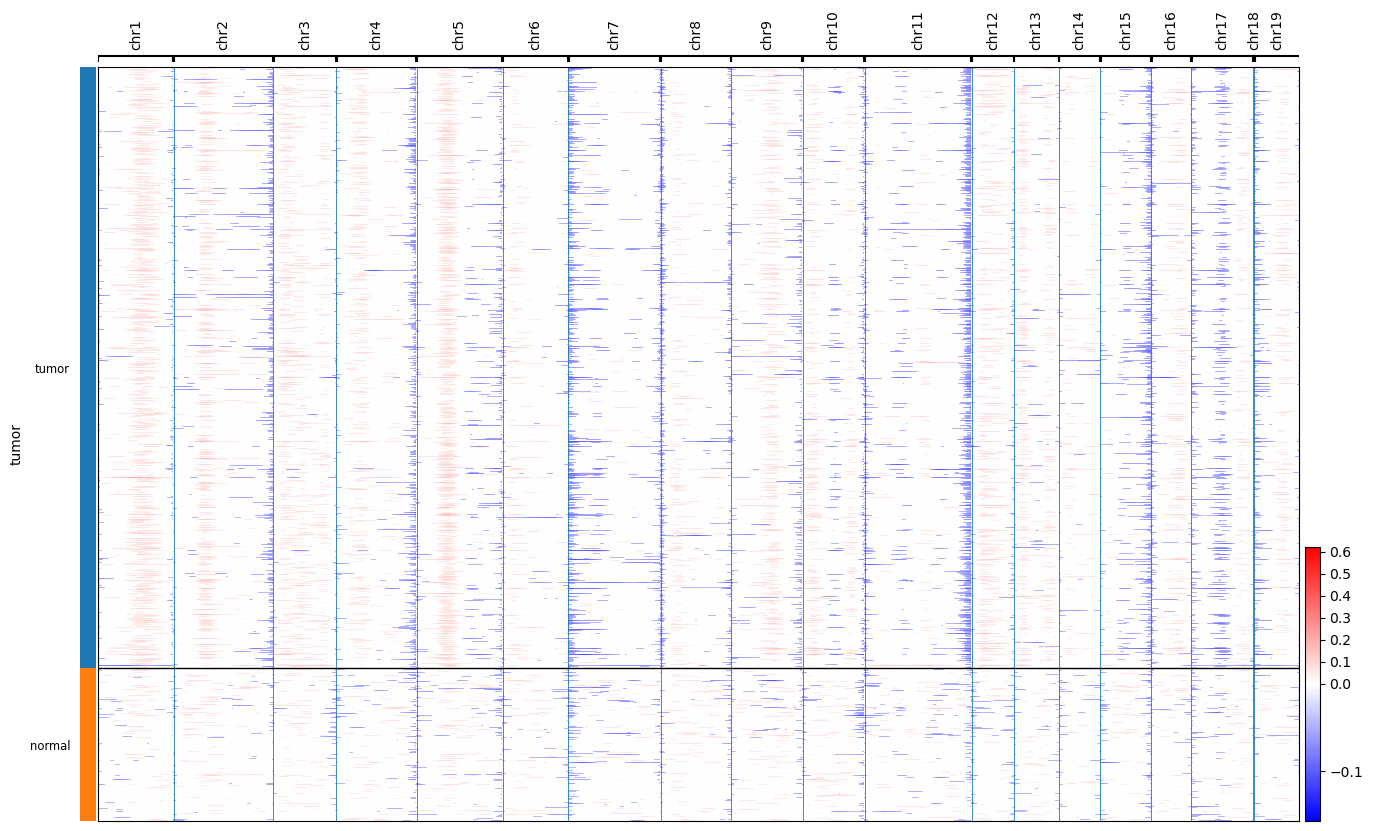

In [216]:
cnv.pl.chromosome_heatmap(apdata, groupby="tumor")

... storing 'treatment' as categorical
... storing 'cs-tumor' as categorical


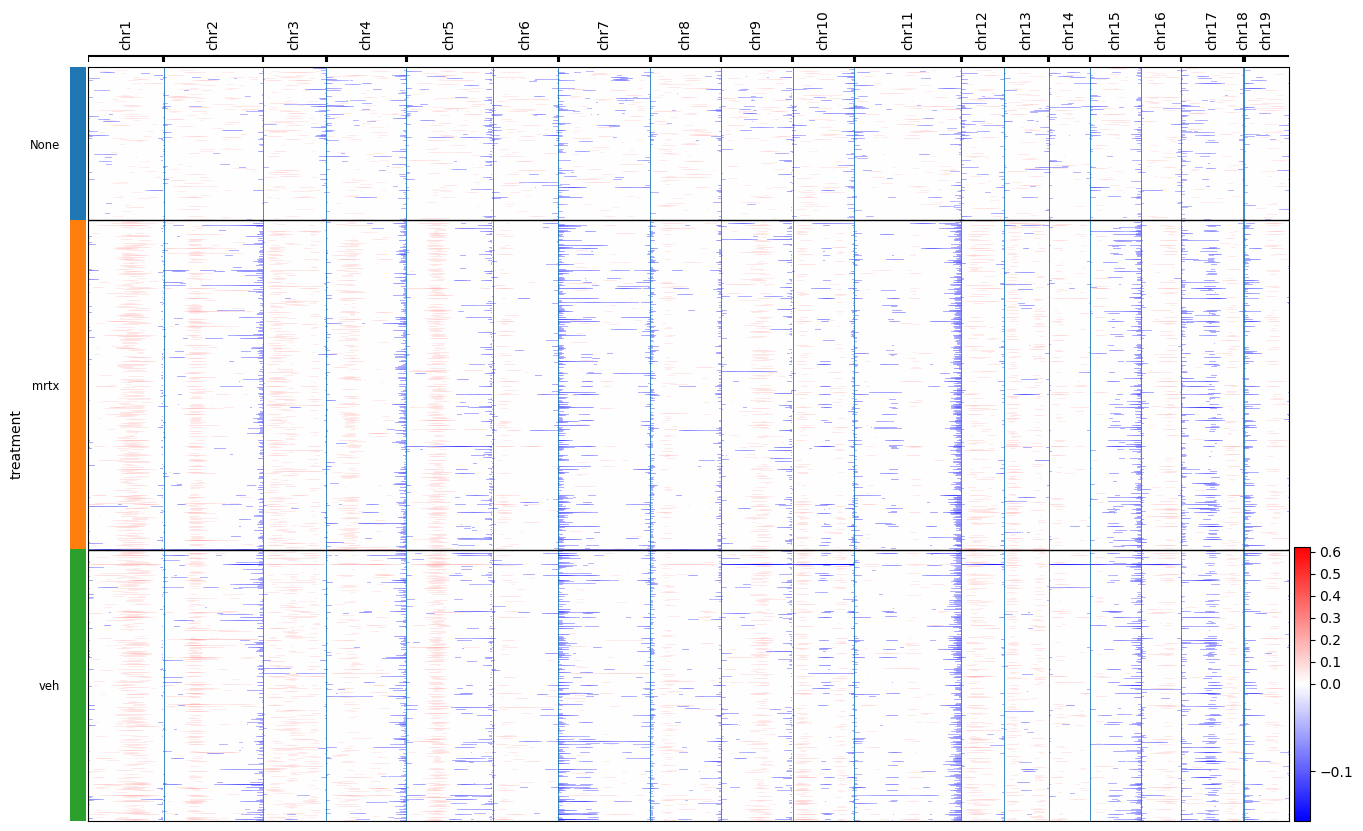

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [222]:
cnv.pl.chromosome_heatmap(apdata, groupby="treatment", save="figures/MouseInferCnvVehMrtx.svg")

In [218]:
apdata.obs["cs-tumor"] = [f"{apdata.obs.iloc[i,10]}-{apdata.obs.iloc[i,9]}" if apdata.obs.iloc[i,11]=="tumor" else "Normal" for i in range(len(apdata.obs))]

... storing 'treatment' as categorical
... storing 'cs-tumor' as categorical


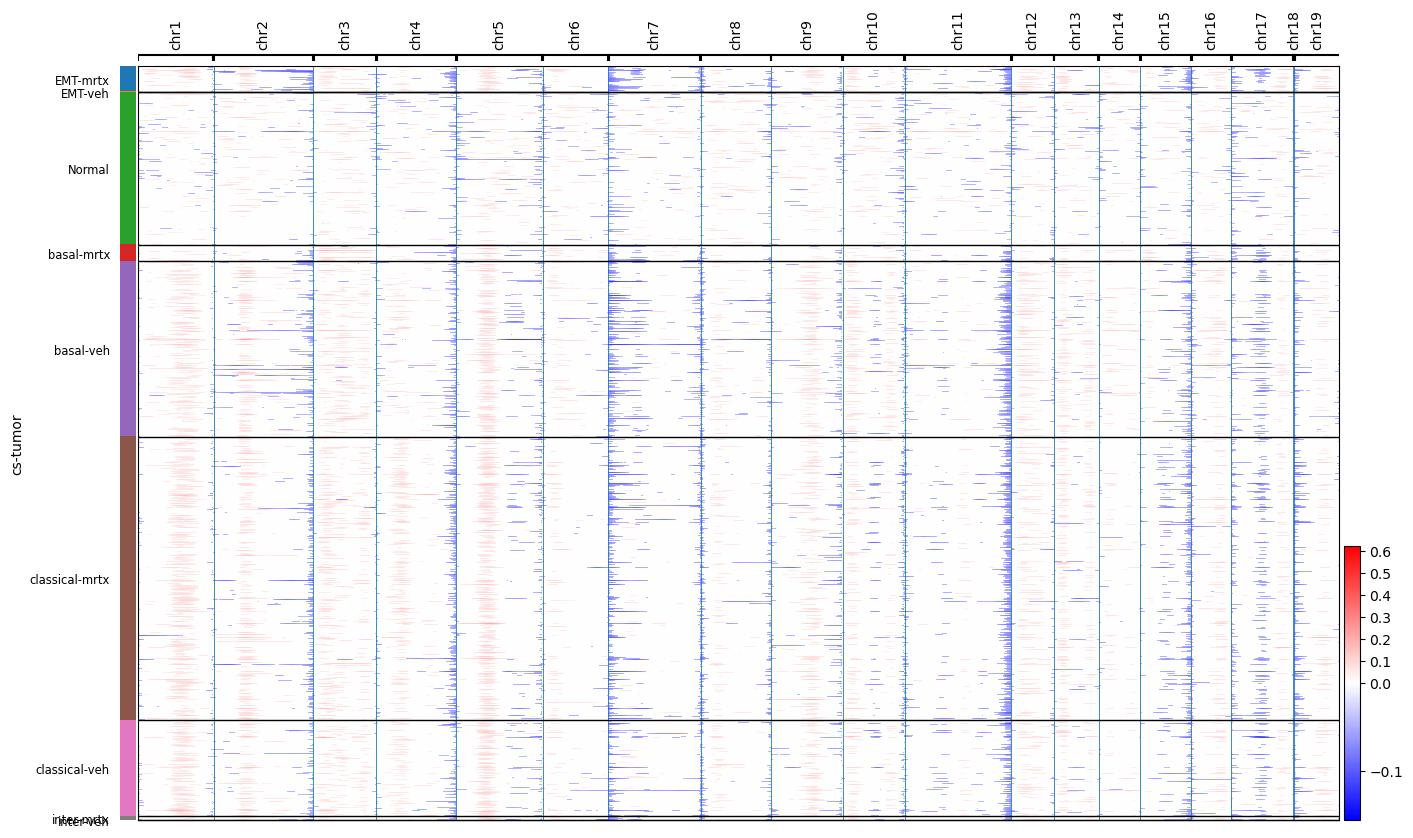

In [223]:
cnv.pl.chromosome_heatmap(apdata, groupby="cs-tumor", save="figures/MouseInferCnvCellState.svg")

... storing 'treatment' as categorical
... storing 'cs-tumor' as categorical


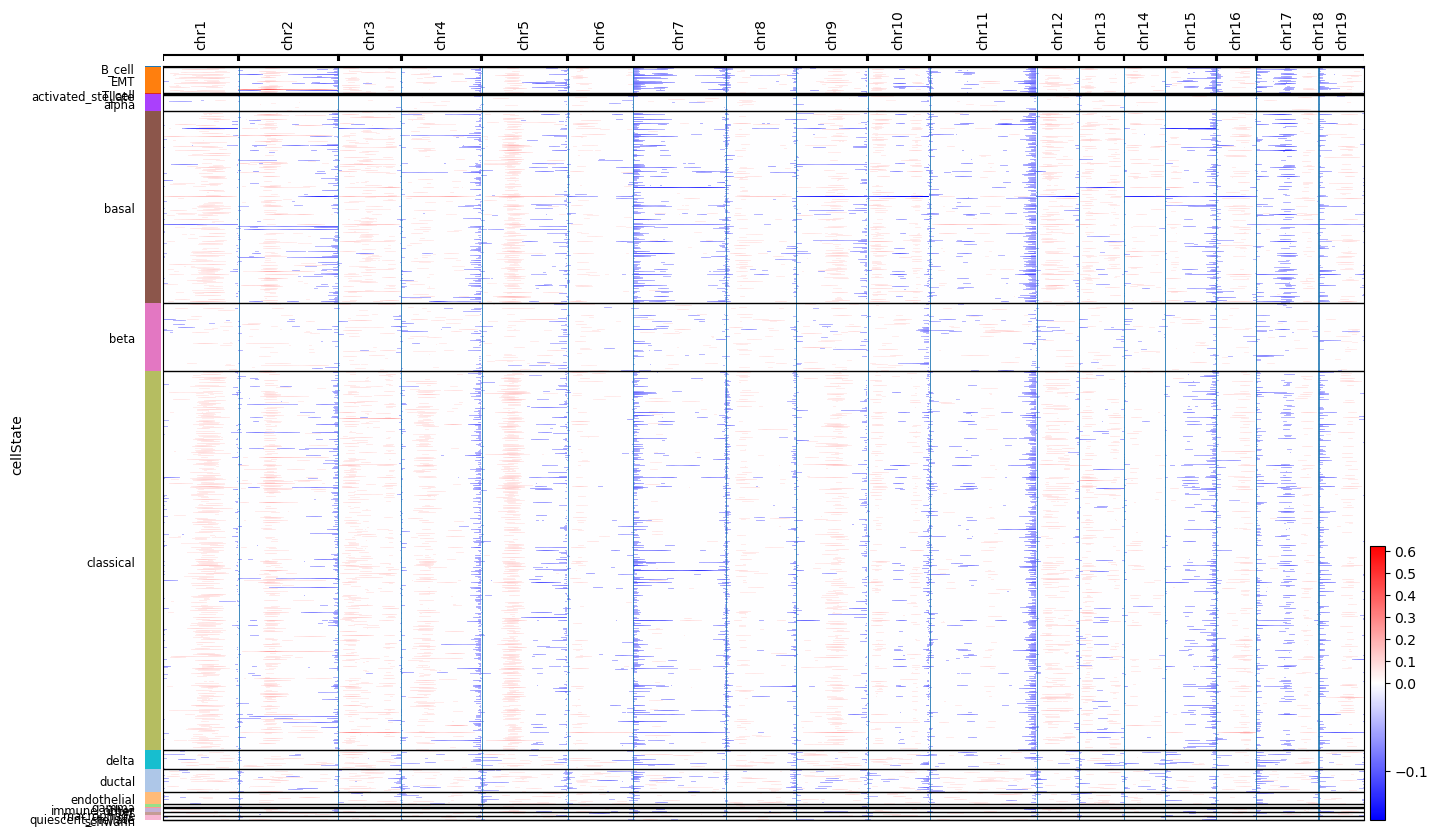

In [220]:
cnv.pl.chromosome_heatmap(apdata, groupby="cellState")